## TODO
* Re-write for more than two classes
* First fix FI, then FM
* Monte Carlo sim to test all permutations; OR:
* Increment steps based on PDF, with each step having an equal prob.
* Jim's suggestion: try replacing EM with land, in addition to water, as I have it now
* Add randomization/monte-carlo into bins- instead of just using mean values (i.e. for size bins, or for FLUX_STEP in senstivity)
* For typical EM fraction: use regional sub-binning instead of UAVSAR footprint 
* Use typical regional values for EM fluxes, the way I use a regional LSD and inun fraction
* install add-ons: git, variable inspector: first install node.js, npm, jupyterlab-git
* Find a plugin to make matplotlib plots interactive like when they appear in sep. window
* make dimensionless version
* (contour plot: fill in color between lines) DONE
* Add size binning: ingest lake size distrib DONE

## Description
This script takes as input the landscape inundation fraction, the emergent macrophyte fraction (fraction of all inundated areas), and flux values for these fractions. It then iterates over probable ranges and plots the total flux's sensitivities to these values, Normalized by area.


| Name  | Description | Value |
|---      |---                |---       |
| INPUTS |
FLUXES | Dictionary of flux values by class	<mg CH4 / m2/ day>| OW: (0, 166); EM: (77, 5800)
FRACTION:IN_TOTAL | Fraction inundated: Range for open water and emergent macrophyte area divided by total landscape area | (10, 38)
FRACTION:EM | Fraction EMERGENT macrophyte: Range for emergent macrophyte area / open water area | (2, 60)
FRACTION:  ... | ...
FRACTION_STEPS | Number of steps for each landcover type (range / increment) |
FRACTION_RATIO | Number of steps for each landcover type (range / increment) |
FLUX_STEPS | Number of steps for flux (range / increment) |


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as colors
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scipy.ndimage as ndi 
from scipy.io import loadmat
from scipy.stats import binned_statistic
import pandas as pd
from uncertainties import unumpy, umath
import qgrid
from python_env import *
qgrid.enable() #enable interactive pandas dataframes
## Plotting style
plt.style.use('/mnt/d/Dropbox/Python/Matplotlib-rcParams/presentation.mplstyle')
# %matplotlib inline

In [2]:
## qgrid parameters
# for help, see https://qgrid.readthedocs.io/en/latest/ or https://github.com/quantopian/qgrid

## set defaults
grid_options = {
        # SlickGrid options
        'fullWidthRows': True, # True
        'syncColumnCellResize': True,
        'forceFitColumns': False, #True
        'defaultColumnWidth': 100, # 150
        'rowHeight': 28,
        'enableColumnReorder': True,
        'enableTextSelectionOnCells': True,
        'editable': True,
        'autoEdit': False,
        'explicitInitialization': True,

        # Qgrid options
        'maxVisibleRows': 10,
        'minVisibleRows': 4,
        'sortable': True,
        'filterable': True,
        'highlightSelectedCell': True,
        'highlightSelectedRow': True
    }

col_options = {
    # SlickGrid column options
    'defaultSortAsc': True,
    'maxWidth': None, # None,
    'minWidth': 30, #30
    'resizable': True,
    'sortable': True,
    'toolTip': "",
    'width': None, # None

    # Qgrid column options
    'editable': True,
}
qgrid.set_defaults(grid_options=grid_options, column_options=col_options)

### Inputs

In [3]:
# fluxes={'OW': 100,
#        'GW': 300,
#        'SW': 200}

FRACTION={
    'IN_TOTAL':(
    (22, 31),
    (10,16),
    (27, 30),
    (37.4, 37.6),
    (10, 37.6)), # Default Fraction Inundated; From Run 35
    'EM':((35, 58),
     (42, 60),
     (12, 21),
     (2, 2.5),
     (0, 100)) #(2, 30) # Default Fraction macrophyte: From Run 35 (range: 2:60)
}
FLUXES={
    'OW': (0, 166), # Open water; From range in: Burger et al 2016	Biogeosciences | Superceded if using LSD
    'EM': (77, 2000), # (77, 3000) #(77, 380)  # Emergent macrophyte; From mean (max = 5800) in: Burger et al 2016	Biogeosciences
    'RATIO': (0, 4000) # based on second and third- highest values of ~170x (0, 200)
}
    # Sensitivity raster dimensions
FRACTION_STEPS=100 # 40
FLUX_STEPS=100 # 40
SITES=('PAD','YFB','YKN','DAR','All') #short names for sites
SITES_LSD = (9,2,7,7,0) # numbers as givin in Lake Size Distribution files
# REGION=0 # Set to -1 if using default; 0=PAD

# LAT=59 # latitude, in degrees (PAD=59)

In [4]:
## Output excel #HERE
synth_table_pth = os.path.join(output_raster_dir_common_roi, 'combined_excel/Synthesis_table.xlsx')

In [5]:
synth_table_pth

'/mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/landcover_raster_burned_subroi_no_smoothing/combined_excel/Synthesis_table.xlsx'

### Lake size distribution inputs

Labels:
    'All'
    'Sagavanirktok River'
    'Yukon Flats Basin'
    'Old Crow Flats'
    'Mackenzie River Delta'
    'Mackenzie River Valley'
    'Canadian Shield Margin'
    'Canadian Shield'
    'Slave River'
    'Peace-Athabasca Delta'
    'Athabasca River'
    'Prairie Potholes North'
    'Prairie Potholes South'
    'Tuktoyaktuk Peninsula'
    []
    []
    []
    []
    []
    []
    []
    'Prairie pothole regions'
    'Canadian Shield'
    'Thermokarst regions'
    'Arctic-boreal wetlands'
    'Lowland river valleys'

In [6]:
lsd_pth='/mnt/d/GoogleDrive/Research/Lake distributions/savedData/fitting_data_regional_4_det.mat' # these directories hold the final version of data used for 2019 paper
lsd_labels_pth='/mnt/d/GoogleDrive/Research/Lake distributions/regionLabels4.mat'

### Size binning data from Holgerson and Raymond 2016

In [7]:
BIN_EDGES=np.array([0, 0.001, 0.01, 0.1, 1, 10, 100, 1000000]) # <km2>
# BIN_EDGES=np.array([0.001, 0.01, 0.1, 1, 10, 100, 10000000]) * 1000000 # <km2> * 1000000 = <m2>
BIN_FLUXES=np.array([2.28, 0.65, 0.28, 0.16,  0.12, 0.10, 0.06])*16.043 # <mmolC (in CH4)/m2/d> * 16.043 = <mg CH4/m2/d>
len(BIN_FLUXES)

7

### Load data

In [8]:
fused_regional=loadmat(lsd_pth, variable_names='Fused_regional', squeeze_me=True)

##############
# for area for each region, see: D:\GoogleDrive\Research\Lake distributions\savedData\out
##############

### Create sensitivity raster

In [9]:
SENSITIVITY={}
FRACTION_POSTINGS={}
FLUX_POSTINGS={}
for si, s in enumerate(SITES):
    print('\nSite: {}'.format(s))
    lsd = fused_regional['Fused_regional'][SITES_LSD[si]] # Lake size distribution for chosen region
    SENSITIVITY[s]=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
    # lsd_tmp=lsd # init
    FRACTION_POSTINGS[s]=np.linspace(FRACTION['EM'][si][0], FRACTION['EM'][si][1], FRACTION_STEPS)
    for Class in FLUXES.keys():
        FLUX_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS)
    lsd_vals = binned_statistic(lsd, lsd, statistic='sum', bins=BIN_EDGES)
    ow_flux_mean=np.sum(lsd_vals.statistic*BIN_FLUXES)/lsd.sum()
    print(f'Open water flux used: {ow_flux_mean:.3} [mg CH_4 / m^2 / day]')
    print(f'EM fraction: {0:0.2f}%\t| Total W area in first bin: \t\
        {lsd_vals.statistic[0]*(100- 0)/100:.2f}\t| Total W area: {np.sum(lsd)*(100- 0)/100:.2f}\n')
    for i in range(FRACTION_STEPS):
        ##############################################
             # toggle if not using LSD
    #     ow_flux_mean=np.mean(FLUX_POSTINGS['OW'])
        ##############################################
            # toggle if using LSD | with lakes changing bins # Results in higher water flux in highest EM bin bc more of the lakes are now small (unrealistic)
    #     lsd_tmp_vals = binned_statistic(lsd_tmp, lsd_tmp, statistic='sum', bins=BIN_EDGES) # could also use np.digitize
    #     ow_flux_mean=np.sum(lsd_tmp_vals.statistic*BIN_FLUXES)/lsd_tmp.sum()
    #     print(f'EM fraction: {FRACTION_POSTINGS[i]:0.2f}%\t| Total W area in first bin: \
    #         {lsd_tmp_vals.statistic[0]:.2f}\t| Total W area: {np.sum(lsd_tmp_vals.statistic):.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
            # toggle if using LSD | with lakes NOT changing bins # Results in lower water flux in highest EM bin
        print(f'EM fraction: {FRACTION_POSTINGS[s][i]:0.2f}%\t| Total W area in first bin: \
            {lsd_vals.statistic[0]*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W area: \
            {np.sum(lsd_vals.statistic)*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
        for j in range(FLUX_STEPS):
            # each cell = <region's inundation fraction> * (<EM fraction> * <EM flux> + <OW fraction> * <OW flux>)
            SENSITIVITY[s][i,j] = np.mean(FRACTION['IN_TOTAL'][si]) / 100 * (FRACTION_POSTINGS[s][i] * FLUX_POSTINGS['EM'][j] + # use median? # note: hard-coded for just two classes: OW and EM
                                (100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100
        


Site: PAD
Open water flux used: 1.36 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.40	| Total W area: 186.62

EM fraction: 35.00%	| Total W area in first bin:             0.26	| Total W area:             121.30	| Total W flux: 0.89
EM fraction: 35.23%	| Total W area in first bin:             0.26	| Total W area:             120.87	| Total W flux: 0.88
EM fraction: 35.46%	| Total W area in first bin:             0.26	| Total W area:             120.43	| Total W flux: 0.88
EM fraction: 35.70%	| Total W area in first bin:             0.26	| Total W area:             120.00	| Total W flux: 0.88
EM fraction: 35.93%	| Total W area in first bin:             0.26	| Total W area:             119.57	| Total W flux: 0.87
EM fraction: 36.16%	| Total W area in first bin:             0.26	| Total W area:             119.13	| Total W flux: 0.87
EM fraction: 36.39%	| Total W area in first bin:             0.26	| Total W area:             118.70	| Total W flux: 0.87


## Add lit values as pts with error bars

In [10]:
## Add fluxes from lit
lit_pth='data/Flux_synthesis.xlsx'
df=pd.read_excel(lit_pth)

## exclude extra rows with no data
df=df[~np.isnan( df['flux_to_plot_[mgCH4_m2_day]'])]

## exclude rows flagged to exclude
df.drop(index=df.query("Exclude==1").index, inplace=True)
df.drop(columns='Exclude', inplace=True)

## remove unecessary columns
df.drop(['Typical flux (gC/m2/yr)', 'flux_to_plot_[mmolCH4_m2_day]', 'confidence_int_min_[mmolCH4_m2_day]', 
        'confidence_int_max_[mmolCH4_m2_day]', 'confidence_int_min_[mmolCH4_m2_day]', 'confidence_int_max_[mmolCH4_m2_day]'], axis=1, inplace=True)

## first set nans to zero
df.loc[np.isnan(df['confidence_int_max_[mgCH4_m2_day]']), ('confidence_int_max_[mgCH4_m2_day]', 'confidence_int_min_[mgCH4_m2_day]')]= \
    0

## fill empty (0) vals with mean
df.loc[np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0), 'confidence_int_min_[mgCH4_m2_day]']= \
    np.mean(df.loc[~np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0), 'confidence_int_min_[mgCH4_m2_day]'])
df.loc[np.isin(df['confidence_int_max_[mgCH4_m2_day]'], 0), 'confidence_int_max_[mgCH4_m2_day]']= \
    np.mean(df.loc[~np.isin(df['confidence_int_max_[mgCH4_m2_day]'], 0), 'confidence_int_max_[mgCH4_m2_day]'])

df.loc[np.isnan(df['EM_percent']), 'EM_percent_conf_in_min']=np.nan # 50 # arbitrary value for lit fluxes CI w no EM % data
df.loc[np.isnan(df['EM_percent']), 'EM_percent_conf_in_max']=np.nan # 50 # arbitrary value for lit fluxes CI w no EM % data
df.loc[np.isnan(df['EM_percent']), 'EM_percent']=np.nan # 50 # arbitrary value for lit fluxes w no EM % data

df.loc[np.isnan(df['EM_percent_conf_in_min']), 'EM_percent_conf_in_min']=np.minimum(df.loc[np.isnan(df['EM_percent_conf_in_min']), 'EM_percent'], 5) # arbitrary value, placeholder for now #  | np.isin(df['EM_percent_conf_in_min'], 0)
df.loc[np.isnan(df['EM_percent_conf_in_max']), 'EM_percent_conf_in_max']=np.minimum(100-df.loc[np.isnan(df['EM_percent_conf_in_max']), 'EM_percent'], 5) # arbitrary value, placeholder for now


## Save copy for ratio plot
dfr=df.copy()

## drop/pop OW vals
idx=df.query('Surface == "OW"').index
df.drop(index=idx, inplace=True)

In [11]:
## Check uniqueness
print('\nReferences:')
print(np.unique(df['Citation']))
print('\nLakes:')
print(np.unique(df['Lake']))


References:
['Bergström et al. 2007' 'Burger et al 2016' 'Casper et al. 2000'
 'DelSontro et al. 2016' 'Dove at al 1999' 'Huttunen et al. 2003'
 'Juutinen et al. 2003' 'Kankaala et al. 2005' 'Kankaala et al. 2013'
 'Larmola et al 2004' 'Ribaudo et al. 2012' 'Smith and Lewis, 1992'
 'Striegl and Michmerhuizen 1998' 'TBD' 'Villa et al, 2021']

Lakes:
['Alinen Mustaja¨rvi' 'Alinen Rautja¨rvi' 'Amazon: high water 1'
 'Amazon: high water 2 ' 'Amazon: low water 1' 'Amazon: low water 2'
 'Balloon Lake #1' 'Beaver Pond (Thompson, MB' 'Busatello Marsh, Italy'
 "Chillowe's Lake" 'Croche/Cromwell/Triton' 'Dillon' 'Dore Lake'
 'Duck Lake, MI' 'Floating Mat 1'
 'Floating Mat: Menyanthes trifoliata\nPonds'
 'Floating Mat: Phragmites australis' 'Floating Mat: Sphagnum'
 'Horkkaja¨rvi' 'Keva¨to¨n' 'Keva¨to¨n 1998' 'Kuohija¨rvi'
 'Lake Ekojärvi 1998, 2000' 'Lake Ekojärvi, Finland, 1997, 1998'
 'Lake Heposelka"' 'Lake Mekkojärvi 2003, 2005'
 'Lake Mekrija¨rvi 1998-1999' 'Lake Mekrija¨rvi 1999-2000'
 'L

In [14]:
## Create variables for plots
## assign: lit vals
FLUXES_LIT=df[df['Orig_paper']!='above2_team' ]['flux_to_plot_[mgCH4_m2_day]'] # use for sens. plot
FRACTION_LIT=df[df['Orig_paper']!='above2_team' ]['EM_percent'] # use for sens. plot
FLUXES_LIT_CI=np.array([df[df['Orig_paper']!='above2_team' ]['confidence_int_min_[mgCH4_m2_day]'], df[df['Orig_paper']!='above2_team' ]['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot
FRACTION_LIT_CI=np.array([df[df['Orig_paper']!='above2_team' ]['EM_percent_conf_in_min'],df[df['Orig_paper']!='above2_team' ]['EM_percent_conf_in_max']]) # use for sens. plot

## assign: field vals
FLUXES_FIELD=df[df['Orig_paper']=='above2_team' ]['flux_to_plot_[mgCH4_m2_day]'] # use for sens. plot
FRACTION_FIELD=df[df['Orig_paper']=='above2_team' ]['EM_percent'] # use for sens. plot
FLUXES_FIELD_CI=np.array([df[df['Orig_paper']=='above2_team' ]['confidence_int_min_[mgCH4_m2_day]'], df[df['Orig_paper']=='above2_team' ]['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot
FRACTION_FIELD_CI=np.array([df[df['Orig_paper']=='above2_team' ]['EM_percent_conf_in_min'],df[df['Orig_paper']=='above2_team' ]['EM_percent_conf_in_max']]) # use for sens. plot

## view
df
# df
# df.describe()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [15]:
## How many lakes?
dfr[dfr.Orig_paper=='above2_team'].Lake.unique().shape

(15,)

In [16]:
## Single contour plot
%matplotlib widget
f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY['All']), 11) #10
num_contours = np.linspace(2, 250, 15) #10

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(sharex=True, figsize=(4,4))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_POSTINGS[s]
    X=FLUX_POSTINGS['EM']
    Z=SENSITIVITY[s]
    
    # Basic contour plot
    CS = ax.contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=500,
        extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f+2)
    ax.set_ylabel('Vegetated fraction (%)', fontsize=f)
#     fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
#     fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax.set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
ax.errorbar(FLUXES_LIT, FRACTION_LIT, FRACTION_LIT_CI,FLUXES_LIT_CI, 'ko', ecolor='gray', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
ax.errorbar(FLUXES_FIELD, FRACTION_FIELD, FRACTION_FIELD_CI,FLUXES_FIELD_CI, 'bo', ecolor='#2D7DC4', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## title
plt.title('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f-2)

## legend
plt.legend(['Published data', 'Field data'], loc='best')

## set window
ax.set_xlim(0, 1000)

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.jpg'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.pdf'
plt.savefig(figPth, dpi=300)

print('Saved fig to:\t{}'.format(figPth))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.pdf


## Plot values as ratios

In [17]:
## workflow: join based on lake name in order to manipulate data frame to include OW - EM pairs
dfr_em=dfr.set_index('Lake').query("Surface != 'OW' ") # data frame ratio em
dfr_ow=dfr.set_index('Lake').query("Surface == 'OW' ") # data frame ratio em
# dfr_ow.columns

## temp join to save text fields # remove Top\paper bc I'm only taking first value of it and Surface bc it is being joined as well
text= dfr_ow.select_dtypes('object').drop(labels=['Topic\Paper', 'Surface'], axis=1).groupby('Lake').first() #.drop(labels='Topic\Paper', axis=1).drop_duplicates() #.groupby('Lake')
# text
# dfr_em.loc[:, ('flux_to_plot_[mgCH4_m2_day]', 'Surface')]

## aggregate dfr_em to average all vegetation types per lake
dfr_em=pd.DataFrame(dfr_em.reset_index().groupby('Lake').mean())
dfr_ow=pd.DataFrame(dfr_ow.reset_index().groupby('Lake').mean())
dfr_ow.index
# text.index
# text.columns
# text.query("Lake == 'Canvasback Lake'")
dfr_em.loc[:, 'flux_to_plot_[mgCH4_m2_day]']

## only keep columns I need (don't use EM % from OW entries - some may be blank)
dfr_ow =dfr_ow.loc[:, ('flux_to_plot_[mgCH4_m2_day]', 'confidence_int_min_[mgCH4_m2_day]', 'confidence_int_max_[mgCH4_m2_day]' )]

## join text back in
dfr_ow=dfr_ow.join(text, 'Lake', how='left')
dfr_ow.index
dfr_ow.loc[:, ('Citation', 'Orig_paper')]

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [18]:
## join (left)
dfr_j= dfr_em.join(dfr_ow, 'Lake', lsuffix='_em', rsuffix='_ow') # data frame ratio join
         # .loc[:, ('flux_to_plot_[mgCH4_m2_day]', 'confidence_int_min_[mgCH4_m2_day]', confidence_int_max_[mgCH4_m2_day]')]

In [19]:
## Check uniqueness
print('\nReferences:')
print(dfr_j['Citation'].unique())
print('\nLakes:')
print(np.unique(dfr_j.index))


References:
['Kankaala et al. 2013' 'Kankaala et al. 2005' 'Smith and Lewis, 1992'
 'TBD' 'Dove at al 1999' 'Ribaudo et al. 2012' 'DelSontro et al. 2016' nan
 'Larmola et al 2004' 'Huttunen et al. 2003' 'Juutinen et al. 2003'
 'Villa et al, 2021' 'Burger et al 2016' 'Casper et al. 2000'
 'Bergström et al. 2007' 'Striegl and Michmerhuizen 1998']

Lakes:
['Alinen Mustaja¨rvi' 'Alinen Rautja¨rvi' 'Amazon: high water 1'
 'Amazon: high water 2 ' 'Amazon: low water 1' 'Amazon: low water 2'
 'Balloon Lake #1' 'Beaver Pond (Thompson, MB' 'Busatello Marsh, Italy'
 "Chillowe's Lake" 'Croche/Cromwell/Triton' 'Dillon' 'Dore Lake'
 'Duck Lake, MI' 'Floating Mat 1'
 'Floating Mat: Menyanthes trifoliata\nPonds'
 'Floating Mat: Phragmites australis' 'Floating Mat: Sphagnum'
 'Horkkaja¨rvi' 'Keva¨to¨n' 'Keva¨to¨n 1998' 'Kuohija¨rvi'
 'Lake Ekojärvi 1998, 2000' 'Lake Ekojärvi, Finland, 1997, 1998'
 'Lake Heposelka"' 'Lake Mekkojärvi 2003, 2005'
 'Lake Mekrija¨rvi 1998-1999' 'Lake Mekrija¨rvi 1999-2000'

In [20]:
## Manually check which lakes are missing OW or EM vals:

missing_val_idx=(np.isnan(dfr_j['flux_to_plot_[mgCH4_m2_day]_ow'])) | (np.isnan(dfr_j['flux_to_plot_[mgCH4_m2_day]_em']))
dfr_j.loc[missing_val_idx, :].index # .loc[missing_val_idx, 'Lake'] # 
# dfr_j.loc[('Amazon: high water 1'), :]
# dfr_j.loc[('Red rock'), :]

Index(['Floating Mat 1', 'Floating Mat: Menyanthes trifoliata\nPonds',
       'Floating Mat: Phragmites australis', 'Floating Mat: Sphagnum',
       'Lake Ekojärvi, Finland, 1997, 1998', 'Lake Vesijärvi, Finland'],
      dtype='object', name='Lake')

In [21]:
## If satisfied, remove these lakes with missing OW or EM vals:

# dfr_j.drop(labels=missing_val_idx.values, inplace=True)
dfr_j=dfr_j.loc[~missing_val_idx, :]
# missing_val_idx

# print unique citations
print('Sources:')
np.unique(dfr_j['Citation'])

Sources:


array(['Bergström et al. 2007', 'Burger et al 2016', 'Casper et al. 2000',
       'DelSontro et al. 2016', 'Dove at al 1999', 'Huttunen et al. 2003',
       'Juutinen et al. 2003', 'Kankaala et al. 2005',
       'Kankaala et al. 2013', 'Larmola et al 2004',
       'Ribaudo et al. 2012', 'Smith and Lewis, 1992',
       'Striegl and Michmerhuizen 1998', 'TBD', 'Villa et al, 2021'],
      dtype=object)

In [22]:
## compute em/ow flux ratio ## hold off on uncertainties for now, bc they are orders of mag larger than values...
dfr_j['CH4_flux_ratio']=dfr_j.loc[:, 'flux_to_plot_[mgCH4_m2_day]_em'] / dfr_j.loc[:,'flux_to_plot_[mgCH4_m2_day]_ow']

## view relevant attributes
dfr_j.loc[:, ('CH4_flux_ratio', 'EM_percent', 'Citation', 'Orig_paper', 'CH4_flux_ratio')]

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [23]:
dfr_j.shape
np.unique(dfr_j.index)
# dfr_j.columns

array(['Alinen Mustaja¨rvi', 'Alinen Rautja¨rvi', 'Amazon: high water 1',
       'Amazon: high water 2 ', 'Amazon: low water 1',
       'Amazon: low water 2', 'Balloon Lake #1',
       'Beaver Pond (Thompson, MB', 'Busatello Marsh, Italy',
       "Chillowe's Lake", 'Croche/Cromwell/Triton', 'Dillon', 'Dore Lake',
       'Duck Lake, MI', 'Horkkaja¨rvi', 'Keva¨to¨n', 'Keva¨to¨n 1998',
       'Kuohija¨rvi', 'Lake Ekojärvi 1998, 2000', 'Lake Heposelka"',
       'Lake Mekkojärvi 2003, 2005', 'Lake Mekrija¨rvi 1998-1999',
       'Lake Mekrija¨rvi 1999-2000', 'Lake Mäkijärvi',
       'Lake Vehmasj€aarvi', 'Long', 'Nimeto¨n',
       'OldWoman\nCreek estuarine wetland', 'Onkimaja¨rvi',
       'Orinico: falling water', 'Orinico: high water', 'Ormaja¨rvi',
       'Pass', 'Pa¨a¨ja¨rvi', 'Peat Pond', 'Postilampi', 'Priest Pot, UK',
       'Rainbow', 'Red rock', "Robert's Cabin Pond", 'Tavilampi',
       'Third Lake', 'Valkea-Kotinen', 'VegSL: 0.01-0.001',
       'VegSL: 0.1-0.01', 'VegSL: 1-0.1', '

In [24]:
## Create variables to plot
## assign: lit vals
FLUXES_RATIO_LIT=dfr_j[dfr_j['Orig_paper']!='above2_team' ]['CH4_flux_ratio'].values # use for sens. plot
FRACTION_RATIO_LIT=dfr_j[dfr_j['Orig_paper']!='above2_team' ]['EM_percent'].values # use for sens. plot
# FLUXES_LIT_CI=np.array([dfr_j[dfr_j['Orig_paper']!='above2_team' ]['confidence_int_min_[mgCH4_m2_day]'], dfr_j[dfr_j['Orig_paper']!='above2_team' ]['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot
FRACTION_RATIO_LIT_CI=np.array([dfr_j[dfr_j['Orig_paper']!='above2_team' ]['EM_percent_conf_in_min'],dfr_j[dfr_j['Orig_paper']!='above2_team' ]['EM_percent_conf_in_max']]) # use for sens. plot
LAKE_LABELS_LIT=dfr_j[dfr_j['Orig_paper']!='above2_team' ].index # text labels

## assign: field vals
FLUXES_RATIO_FIELD=dfr_j[dfr_j['Orig_paper']=='above2_team' ]['CH4_flux_ratio'].values # use for sens. plot
FRACTION_RATIO_FIELD=dfr_j[dfr_j['Orig_paper']=='above2_team' ]['EM_percent'].values # use for sens. plot
# FLUXES_FIELD_CI=np.array([dfr_j[dfr_j['Orig_paper']=='above2_team' ]['confidence_int_min_[mgCH4_m2_day]'], dfr_j[dfr_j['Orig_paper']=='above2_team' ]['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot
FRACTION_RATIO_FIELD_CI=np.array([dfr_j[dfr_j['Orig_paper']=='above2_team' ]['EM_percent_conf_in_min'],dfr_j[dfr_j['Orig_paper']=='above2_team' ]['EM_percent_conf_in_max']]) # use for sens. plot
LAKE_LABELS_FIELD=dfr_j[dfr_j['Orig_paper']=='above2_team' ].index # text labels

## view
dfr_j.columns
# dfr_j
# dfr_j.describe()

Index(['flux_to_plot_[mgCH4_m2_day]_em',
       'confidence_int_min_[mgCH4_m2_day]_em',
       'confidence_int_max_[mgCH4_m2_day]_em', 'M_percent', 'EM_percent',
       'EM_percent_conf_in_min', 'EM_percent_conf_in_max',
       'flux_to_plot_[mgCH4_m2_day]_ow',
       'confidence_int_min_[mgCH4_m2_day]_ow',
       'confidence_int_max_[mgCH4_m2_day]_ow', 'Citation', 'Journal',
       'Orig_paper', 'Pathway', 'Notes', 'CH4_flux_ratio'],
      dtype='object')

In [35]:
## Single contour plot with histograms v3 (log-log)
%matplotlib widget
from math import log

f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY_RATIO['All']), 11) #10
xlim_max=dfr_j.CH4_flux_ratio.max() #200 # max x limit
# plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('default')
bins=25 # number of histogram bins

#####################linear x axis
# xlim=150
# xscale='linear'
# num_contours = np.arange(1, xlim*2, np.round(xlim/14)) # for linear xscale
# xlim_min=0
# xlim_max=xlim
#####################log x axis
xscale='log'
# num_contours = np.logspace(-1, np.log10(xlim*1), 10, base=10) # for log xscale
base=4 #np.e
# num_contours = np.logspace(log(0.01, 10), log(xlim*100, 10), 12, base=base) # for log xscale
# num_contours = np.sort(np.append(np.logspace(log(0.01, 10), log(xlim*10, 10), 12), np.array([ 0.9, 0.95, 0.99, 1.01, 1.05, 1.1]))) # for log xscale
# num_contours = np.sort(np.hstack([num_contours, np.array([1.])]))
# num_contours = np.linspace(0.1, xlim*4, 10) # for log xscale
xlim_min=0.0005
bins_flux=np.logspace(np.log10(xlim_min), np.log10(xlim_max)+1, bins)
#############################
#####################linear y axis
# yscale='linear'

#####################log y axis
yscale='log'
ylim_min=0.1
bins_fraction=np.logspace(log(ylim_min), np.log10(100), bins)
#############################

# num_contours = np.linspace(1, xlim*2, 11) #10

## definitions for the axes
left, width = 0.12, 0.73
bottom, height = 0.1, 0.75
spacing = 0.02
hist_height = 1 - bottom - height - spacing*2 # 0.1

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, hist_height]
rect_histy = [left + width + spacing, bottom, hist_height, height]

## Define axes
plt.figure(figsize=(5,5)) # no effect: constrained_layout=True
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']): # unnecessary loop
        
#         # define dims
#     Y=FRACTION_RATIO_POSTINGS[s]
#     X=FLUX_RATIO_POSTINGS['RATIO']
#     Z=SENSITIVITY_RATIO[s]
    
    # Basic contour plot
#     CS = ax_scatter.contour(X, Y, Z, num_contours, colors='k', cmap=None, alpha=0.4, \
#                             norm=colors.LogNorm(0.5, vmax=num_contours[-1]), # norm=colors.LogNorm(vmin=0, vmax=xlim*1.3), #
#         extent=(FLUXES['RATIO'][0], FLUXES['RATIO'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]), linewidths=2)

#         # Recast levels to new class
#     CS.levels = [nf(val) for val in CS.levels]
#     clabel_locs=[] #[(0.019, 91.70)]*10
#     ax_scatter.clabel(CS, CS.levels, inline=True, fontsize=10, use_clabeltext =True, fmt=fmt) #, manual=clabel_locs)
    
    ax_scatter.set_xlabel("Littoral:pelagic flux ratio", fontsize=f)
    ax_scatter.set_ylabel('Vegetated littoral area (%)', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
color_lit=[0.00]*3 #'#7938BA' #'#607552'#'#DE9D49'
ax_scatter.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 's', color=color_lit, ecolor=color_lit, fillstyle='none', alpha=0.6, label='Published data') # , clip_box=(0,0,6000,100) color='#1C6A78', ecolor='#1C6A78'

## Superimpose errorbar plot: field values
color_field = [0.00]*3 # '#B37C2B' #'#B05DB3' #'#136491'
ax_scatter.errorbar(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, FRACTION_RATIO_FIELD_CI, None, 'o', color=color_field, ecolor=color_field, fillstyle='none', alpha=0.6, label='Field data') # , clip_box=(0,0,6000,100) color='#6178FA', ecolor='#6178FA'

## Add shading
area_x=(1,1e5)
area_y=(100, 100)
ax_scatter.fill_between(area_x, area_y, alpha=0.1, color=(0.1,0.1,0.1))

## histograms
hist_color = '#999999' #[0.35]*3
ax_histx.hist(np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)), bins=bins_flux, color = hist_color) # bins=bins # bins=50
ax_histy.hist(np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT)), bins=bins_fraction, color = hist_color, orientation='horizontal')

## title
# ax_scatter.set_title('Water surface flux contribution ratio (total:OW)', fontsize=f-2)

## legend
ax_scatter.legend(loc=[0.01, 0.05], fontsize=f, borderpad= 0.2, labelspacing=0.1, handlelength=0.5) # loc=[0.01, 0.45]

## set window and axes

#####################linear axis
# ax_scatter.set_xlim(0, xlim_max) #FLUXES['RATIO'][1]/1) #FLUXES['RATIO'][1]/1)
################################

ax_scatter.set_xscale(xscale)
ax_scatter.set_yscale(yscale)
ax_scatter.set_ylim(ylim_min, 100)
ax_scatter.set_xlim(xlim_min, xlim_max*2)

ax_histx.set_xlim(ax_scatter.get_xlim()) # ax_scatter.get_xlim() # 0,10
ax_histx.set_xscale(xscale)
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_yscale(yscale)


## style
# fig.linewidth(4)

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHistsLogLog.jpg'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHistsLogLog.pdf'
plt.savefig(figPth, dpi=300)

print('Saved fig to:\t{}'.format(figPth))
print('Contour values: {}'.format(num_contours))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHistsLogLog.pdf
Contour values: [  2.          19.71428571  37.42857143  55.14285714  72.85714286
  90.57142857 108.28571429 126.         143.71428571 161.42857143
 179.14285714 196.85714286 214.57142857 232.28571429 250.        ]


In [24]:
ax_scatter.get_ylim()


(0.1, 100.0)

In [40]:
## Save file
dfr_j.to_excel(synth_table_pth)

In [25]:
nf(60.1)
CS.levels
# plt.rcParams['legend.labelspacing']
# CS.allsegs[0][0]
# xscale
# np.concatenate(num_contours, np.array([1.]), axis=0)
# num_contours.shape
# np.sort(np.hstack([num_contours, np.array([1.])]))
# np.sort(np.hstack([num_contours, np.array([1.])]))
num_contours

array([  2.        ,  19.71428571,  37.42857143,  55.14285714,
        72.85714286,  90.57142857, 108.28571429, 126.        ,
       143.71428571, 161.42857143, 179.14285714, 196.85714286,
       214.57142857, 232.28571429, 250.        ])

In [26]:
colors.LogNorm(0.0001, vmax=num_contours[-1]).scaled

<bound method Normalize.scaled of <matplotlib.colors.LogNorm object at 0x7f96b0fa9d30>>

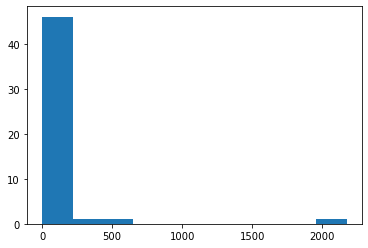

array([5.00000000e-04, 1.04045665e-03, 2.16510007e-03, 4.50538553e-03,
       9.37531665e-03, 1.95092211e-02, 4.05969975e-02, 8.44788320e-02,
       1.75793125e-01, 3.65810251e-01, 7.61219414e-01, 1.58403160e+00,
       3.29623242e+00, 6.85917387e+00, 1.42733461e+01, 2.97015957e+01,
       6.18064454e+01, 1.28613854e+02, 2.67634279e+02, 5.56923729e+02,
       1.15890999e+03, 2.41159121e+03, 5.01831222e+03, 1.04426726e+04,
       2.17302963e+04])

In [27]:
%matplotlib inline
plt.hist(np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT))) #, bins=bins_flux, range=(0, xmax))
plt.show()
bins_flux

## Additional plots and comparisons among flux data

Saved fig to:	/mnt/d/pic/UAVSAR_classification/boxPlot1.jpg


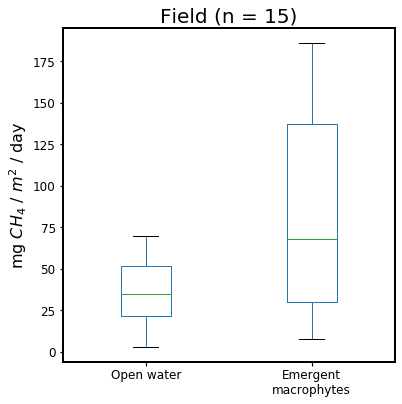

In [50]:
## Additional bar plot
%matplotlib inline
# df[df['Orig_paper']=='above2_team' ][df['Surface']=='EM' ] #['flux_to_plot_[mgCH4_m2_day]']
plt.rcParams.update({'font.size': 14})  
fig, ax = plt.subplots(figsize=(6,5.5)) #figsize=(4,4))
dfr.query("Orig_paper=='above2_team' & Surface == 'OW'").plot.box(y='flux_to_plot_[mgCH4_m2_day]', ax=ax, positions=[0.5], widths=0.3) # ,  boxprops={'linewidth':2}
dfr.query("Orig_paper=='above2_team' & Surface != 'OW'").plot.box(y='flux_to_plot_[mgCH4_m2_day]', ax=ax, positions=[1.5], widths=0.3)
dfr.query("Orig_paper=='above2_team'")
n=np.unique(dfr.query("Orig_paper=='above2_team' & Surface == 'OW'").Lake).shape[0]
ax.set(xticklabels=['Open water', 'Emergent\nmacrophytes'], ylabel='mg $CH_4$ / $m^2$ / day', aspect=0.01, title= 'Field (n = '+str(n)+')')
# fig.set(linewidth=1)
fig.constrained_layout=True

## Save
figPth='/mnt/d/pic/UAVSAR_classification/boxPlot1.pdf'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/boxPlot1.jpg'
plt.savefig(figPth, dpi=300)
print('Saved fig to:\t{}'.format(figPth))

In [53]:
np.unique(dfr.query("Orig_paper=='above2_team' & Surface == 'OW'").Lake)

array(['Balloon Lake', 'Balloon Lake #1', 'Big Beaver', "Chillowe's Lake",
       'Dore Lake', 'Flett Lake', 'High Lake', 'Horseshoe', 'Limon Lake',
       'Little Lake', 'Long Lake', 'PAD3', "Robert's Cabin Pond",
       'Roche Pond', 'Third Lake'], dtype=object)

In [29]:
np.unique(dfr.query("Orig_paper=='above2_team' & Surface == 'OW'").Lake).shape[0]
np.unique(dfr.query("Orig_paper=='above2_team' & Surface == 'OW'").Lake)

array(['Balloon Lake', 'Balloon Lake #1', 'Big Beaver', "Chillowe's Lake",
       'Dore Lake', 'Flett Lake', 'High Lake', 'Horseshoe', 'Limon Lake',
       'Little Lake', 'Long Lake', 'PAD3', "Robert's Cabin Pond",
       'Roche Pond', 'Third Lake'], dtype=object)

array([62.054324, 34.925611, 29.118045, 69.578491, 22.075168, 55.460651,
       34.49245 , 53.90448 , 51.3376  , 48.129   , 44.9204  , 16.043   ,
        8.0215  , 24.0645  ,  3.2086  , 20.8559  ])

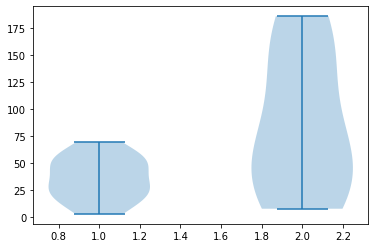

In [30]:
## Violin plot
%matplotlib inline

fig, ax = plt.subplots() #figsize=(4,4))
plot_ow=dfr.query("Orig_paper=='above2_team' & Surface == 'OW'")['flux_to_plot_[mgCH4_m2_day]'].to_numpy()
plot_em=dfr.query("Orig_paper=='above2_team' & Surface != 'OW'")['flux_to_plot_[mgCH4_m2_day]'].to_numpy()
ax.violinplot([plot_ow, plot_em])
# ax.violinplot(plot_em)
plot_ow
# ax.set(xticklabels=['Open water', 'Emergent\nmacrophytes'], ylabel='mg $CH_4$ / $m^2$ / day', aspect=0.01)

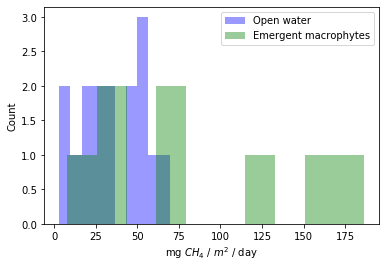

In [31]:
## Overlapping histograms
%matplotlib inline

fig, ax = plt.subplots() #figsize=(4,4))
a=0.4
ax.hist(plot_ow, alpha=a, color='b', label='Open water')
ax.hist(plot_em, alpha=a, color='g', label='Emergent macrophytes')
ax.set(xlabel='mg $CH_4$ / $m^2$ / day', ylabel='Count')
ax.legend()
# fig.constrained_layout=True

Saved fig to:	/mnt/d/pic/UAVSAR_classification/boxPlot2_paired_field.jpg


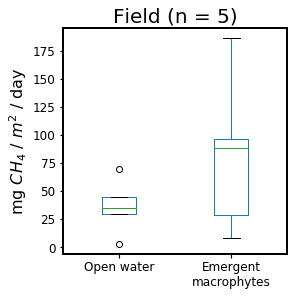

In [48]:
## Only lakes with both OW and EM measurements
%matplotlib inline

# plt.rcParams.update({'font.size': 14})  
# plt.rcParams.update({'font.size': 14, 'lines.linewidth':4, 'axes.linewidth': 1.2, 'lines.markersize': 6.0, })
fig, ax = plt.subplots() #figsize=(4,4))
dfr_j.query("Orig_paper=='above2_team'").plot.box(y='flux_to_plot_[mgCH4_m2_day]_ow', ax=ax, positions=[0.5], widths=0.3) # ,  boxprops={'linewidth':2}
dfr_j.query("Orig_paper=='above2_team'").plot.box(y='flux_to_plot_[mgCH4_m2_day]_em', ax=ax, positions=[1.5], widths=0.3)
ax.set(xticklabels=['Open water', 'Emergent\nmacrophytes'], ylabel='mg $CH_4$ / $m^2$ / day', aspect=0.01, title= 'Field (n = {:})'.format(len(dfr_j.query("Orig_paper=='above2_team'"))))
dfr_j.query("Orig_paper=='above2_team'")

## Save
figPth='/mnt/d/pic/UAVSAR_classification/boxPlot2_paired_field.pdf'
plt.savefig(figPth, dpi=300, bbox_inches="tight")
figPth='/mnt/d/pic/UAVSAR_classification/boxPlot2_paired_field.jpg'
plt.savefig(figPth, dpi=300, bbox_inches="tight")
print('Saved fig to:\t{}'.format(figPth))

Saved fig to:	/mnt/d/pic/UAVSAR_classification/boxPlot3_lit.jpg


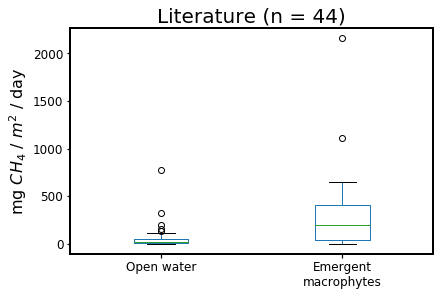

In [49]:
## Now plot for LITERATURE lakes with both OW and EM measurements
%matplotlib inline

# plt.rcParams.update({'font.size': 14})  
# plt.rcParams.update({'font.size': 14, 'lines.linewidth':4, 'axes.linewidth': 1.2, 'lines.markersize': 6.0, })
fig, ax = plt.subplots() #figsize=(4,4))
dfr_j.query("Orig_paper!='above2_team'").plot.box(y='flux_to_plot_[mgCH4_m2_day]_ow', ax=ax, positions=[0.5], widths=0.3) # ,  boxprops={'linewidth':2}
dfr_j.query("Orig_paper!='above2_team'").plot.box(y='flux_to_plot_[mgCH4_m2_day]_em', ax=ax, positions=[1.5], widths=0.3)
n=dfr_j.query("Orig_paper!='above2_team'").shape[0]
ax.set(xticklabels=['Open water', 'Emergent\nmacrophytes'], ylabel='mg $CH_4$ / $m^2$ / day', title= 'Literature (n = {:})'.format(n))
# plt.constrained_layout()

## Save
figPth='/mnt/d/pic/UAVSAR_classification/boxPlot3_lit.pdf'
plt.savefig(figPth, dpi=300, bbox_inches="tight")
figPth='/mnt/d/pic/UAVSAR_classification/boxPlot3_lit.jpg'
plt.savefig(figPth, dpi=300, bbox_inches="tight")
print('Saved fig to:\t{}'.format(figPth))

Saved fig to:	/mnt/d/pic/UAVSAR_classification/em_ow_scatter.jpg


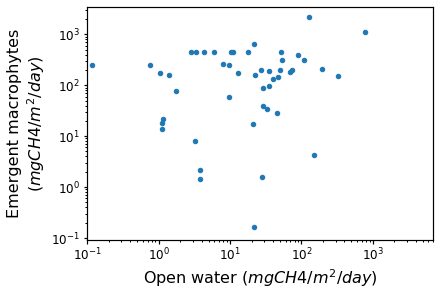

In [41]:
## EM vs OW flux scatter plot
dfr_j.plot.scatter(x='flux_to_plot_[mgCH4_m2_day]_ow', y='flux_to_plot_[mgCH4_m2_day]_em')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('Open water ($mg CH4/m^2/day$)')
plt.ylabel('Emergent macrophytes\n($mg CH4/m^2/day$)')
plt.xlim([1e-1, 7e3])
plt.xlim([1e-1, 7e3])

## Save
figPth='/mnt/d/pic/UAVSAR_classification/em_ow_scatter.pdf'
plt.savefig(figPth, dpi=300, bbox_inches="tight")
figPth='/mnt/d/pic/UAVSAR_classification/em_ow_scatter.jpg'
plt.savefig(figPth, dpi=300, bbox_inches="tight")
print('Saved fig to:\t{}'.format(figPth))

# Stats for paper

In [23]:
## Find flux stats

dfr_j['Field']=0 # new categorical var for new, field vals vs lit
dfr_j.loc[dfr_j.Orig_paper == 'above2_team', 'Field']=1

# Display
# dfr_j.groupby('Orig_paper').mean().CH4_flux_ratio
display(dfr_j.groupby('Field').mean().CH4_flux_ratio)
display(dfr_j.groupby('Field').median().CH4_flux_ratio)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [24]:
print('{} of {} literature lakes have flux ratios > 1.'.format(np.sum(dfr_j.query("Orig_paper!='above2_team'").CH4_flux_ratio>=1), len(dfr_j.query("Orig_paper!='above2_team'").CH4_flux_ratio)))

37 of 44 literature lakes have flux ratios > 1.


In [25]:
len(dfr_j.query("Orig_paper!='above2_team'").CH4_flux_ratio)

44

In [26]:
## Stats test: (paired) t-test on paired EM/OW field values

from scipy.stats import ttest_rel

plot_paired_ow = dfr_j.query("Orig_paper=='above2_team'")['flux_to_plot_[mgCH4_m2_day]_ow']
plot_paired_em = dfr_j.query("Orig_paper=='above2_team'")['flux_to_plot_[mgCH4_m2_day]_em']
t, p = ttest_rel(plot_paired_em, plot_paired_ow)
print(f'Result:\n\tt = {t:.2}\n\tp = {p:.2}')
print(f'\tn = {len(plot_paired_ow)}')

Result:
	t = 1.9
	p = 0.13
	n = 5


In [27]:
## Stats test: (paired) t-test on paired EM/OW LITERATURE values

plot_paired_ow_lit = dfr_j.query("Orig_paper!='above2_team'")['flux_to_plot_[mgCH4_m2_day]_ow']
plot_paired_em_lit = dfr_j.query("Orig_paper!='above2_team'")['flux_to_plot_[mgCH4_m2_day]_em']
t, p = ttest_rel(plot_paired_em_lit, plot_paired_ow_lit)
print(f'Result:\n\tt = {t:.2}\n\tp = {p:.2}')
print(f'\tn = {len(plot_paired_ow_lit)}')

Result:
	t = 4.3
	p = 9.8e-05
	n = 44


In [28]:
## Stats test: t-test on non-paired EM/OW FIELD values (more OW than EM)

from scipy.stats import ttest_ind
ttest_ind(plot_em, plot_ow, equal_var=False)
t, p = ttest_rel(plot_paired_em_lit, plot_paired_ow_lit)
print(f'Result:\n\tt = {t:.2}\n\tp = {p:.2}')
print(f'\tn: {len(plot_ow)} (OW), {len(plot_em)} (EM)')

NameError: name 'plot_em' is not defined

In [29]:
## Stats test: t-test on non-paired EM/OW FIELD values (more OW than EM)
## log-transform

from scipy.stats import ttest_ind
ttest_ind(plot_em, plot_ow, equal_var=False)
t, p = ttest_rel(np.log(plot_paired_em_lit), np.log(plot_paired_ow_lit))
print(f'Result:\n\tt = {t:.2}\n\tp = {p:.2}')
print(f'\tn: {len(plot_ow)} (OW), {len(plot_em)} (EM)')

NameError: name 'plot_em' is not defined

In [31]:
## How many fluxes do I have?

print(FLUXES_FIELD.shape)
print(FLUXES_LIT.shape)
print(FLUXES_RATIO_FIELD.shape)
print(FLUXES_RATIO_LIT.shape)

(8,)
(53,)
(5,)
(44,)


In [32]:
## Another to view
%matplotlib inline

print(dfr.query("Orig_paper == 'above2_team' & Surface == 'EM'").shape[0])
print(dfr.query("Orig_paper == 'above2_team' & Surface == 'OW'").shape[0])
print(dfr_j.query("Orig_paper == 'above2_team'").shape[0])
dfr_j.query("Orig_paper == 'above2_team'")
# dfr.query("Orig_paper == 'above2_team' & Surface == 'EM'")

8
18
5


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [33]:
## uncertainty propogation

ch4_em_min=unumpy.uarray(dfr_j['flux_to_plot_[mgCH4_m2_day]_em'], dfr_j['confidence_int_min_[mgCH4_m2_day]_em'])
ch4_em_max=unumpy.uarray(dfr_j['flux_to_plot_[mgCH4_m2_day]_em'], dfr_j['confidence_int_max_[mgCH4_m2_day]_em'])

ch4_ow_min=unumpy.uarray(dfr_j['flux_to_plot_[mgCH4_m2_day]_ow'], dfr_j['confidence_int_min_[mgCH4_m2_day]_ow'])
ch4_ow_max=unumpy.uarray(dfr_j['flux_to_plot_[mgCH4_m2_day]_ow'], dfr_j['confidence_int_max_[mgCH4_m2_day]_ow'])

## calculate uncertainty in ratio
ch4_flux_ratio_min=ch4_em_min / ch4_ow_min
ch4_flux_ratio_max=ch4_em_max / ch4_ow_max

## view
# ch4_ow_max
# ch4_em_min
# ch4_flux_ratio_max - ch4_flux_ratio_min
# np.quantile(ch4_flux_ratio_max, 0.99)
# np.sort(ch4_flux_ratio_max)
# # dfr_j
# dfr_j['confidence_int_max_[mgCH4_m2_day]_ow']
# np.any(np.isnan(dfr['confidence_int_min_[mgCH4_m2_day]']))
# np.any(np.isnan(dfr_j['confidence_int_max_[mgCH4_m2_day]_ow']))
# dfr_j.loc[np.isnan(dfr_j['confidence_int_max_[mgCH4_m2_day]_ow']), :]
# np.isnan(dfr_j['confidence_int_max_[mgCH4_m2_day]_ow'])
# dfr_j.columns

NegativeStdDev: The standard deviation cannot be negative

## Old contour plots

In [39]:
## Create sensitivity ratio raster

## modify value to get smaller bins
FLUX_STEPS=500 # 40
FRACTION_STEPS=500

SENSITIVITY_RATIO={}
FRACTION_RATIO_POSTINGS={}
FLUX_RATIO_POSTINGS={}
for si, s in enumerate(SITES):
    print('\nSite: {}'.format(s))
    lsd = fused_regional['Fused_regional'][SITES_LSD[si]] # Lake size distribution for chosen region
    SENSITIVITY_RATIO[s]=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
    # lsd_tmp=lsd # init
    FRACTION_RATIO_POSTINGS[s]=np.linspace(FRACTION['EM'][si][0], FRACTION['EM'][si][1], FRACTION_STEPS)
    for Class in FLUXES.keys():
        FLUX_RATIO_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS) #********#
    lsd_vals = binned_statistic(lsd, lsd, statistic='sum', bins=BIN_EDGES)
    ow_flux_mean=np.sum(lsd_vals.statistic*BIN_FLUXES)/lsd.sum()
    print(f'Open water flux used: {ow_flux_mean:.3} [mg CH_4 / m^2 / day]')
    print(f'EM fraction: {0:0.2f}%\t| Total W area in first bin: \t\
        {lsd_vals.statistic[0]*(100- 0)/100:.2f}\t| Total W area: {np.sum(lsd)*(100- 0)/100:.2f}\n')
    for i in range(FRACTION_STEPS):
        ##############################################
             # toggle if not using LSD
    #     ow_flux_mean=np.mean(FLUX_RATIO_POSTINGS['OW'])
        ##############################################
            # toggle if using LSD | with lakes changing bins # Results in higher water flux in highest EM bin bc more of the lakes are now small (unrealistic)
    #     lsd_tmp_vals = binned_statistic(lsd_tmp, lsd_tmp, statistic='sum', bins=BIN_EDGES) # could also use np.digitize
    #     ow_flux_mean=np.sum(lsd_tmp_vals.statistic*BIN_FLUXES)/lsd_tmp.sum()
    #     print(f'EM fraction: {FRACTION_RATIO_POSTINGS[i]:0.2f}%\t| Total W area in first bin: \
    #         {lsd_tmp_vals.statistic[0]:.2f}\t| Total W area: {np.sum(lsd_tmp_vals.statistic):.2f}\t| Total W flux: {((100- FRACTION_RATIO_POSTINGS[i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
            # toggle if using LSD | with lakes NOT changing bins # Results in lower water flux in highest EM bin
#         print(f'EM fraction: {FRACTION_RATIO_POSTINGS[s][i]:0.2f}%\t| Total W area in first bin: \
#             {lsd_vals.statistic[0]*(100- FRACTION_RATIO_POSTINGS[s][i])/100:.2f}\t| Total W area: \
#             {np.sum(lsd_vals.statistic)*(100- FRACTION_RATIO_POSTINGS[s][i])/100:.2f}\t| Total W flux: {((100- FRACTION_RATIO_POSTINGS[s][i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
        for j in range(FLUX_STEPS):
            # each cell = (<EM fraction> * <EM flux> + <OW fraction> * <OW flux>)
            SENSITIVITY_RATIO[s][i,j] = (FRACTION_RATIO_POSTINGS[s][i] * FLUX_RATIO_POSTINGS['RATIO'][j] * ow_flux_mean + # use median? # note: hard-coded for just two classes: OW and EM
                                (100- FRACTION_RATIO_POSTINGS[s][i]) * ow_flux_mean) / 100 / ow_flux_mean
        


Site: PAD
Open water flux used: 1.36 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.40	| Total W area: 186.62


Site: YFB
Open water flux used: 3.53 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        1.38	| Total W area: 178.65


Site: YKN
Open water flux used: 1.37 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.44	| Total W area: 2082.63


Site: DAR
Open water flux used: 1.37 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.44	| Total W area: 2082.63


Site: All
Open water flux used: 1.56 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        7.02	| Total W area: 5964.35



In [40]:
## Single contour plot
%matplotlib widget

f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY_RATIO['All']), 11) #10
xlim=200 # max x limit
# plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('default')
#####################linear axis
# xscale='linear'
# num_contours = np.arange(1, xlim*2, np.round(xlim/14)) # for linear xscale
# xlim_min=0
################################

#####################log axis
xscale='log'
num_contours = np.logspace(-3, np.log10(xlim*2), np.round(xlim/14)) # for log xscale
xlim_min=0.005
#############################

# num_contours = np.linspace(1, xlim*2, 11) #10


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(sharex=True, figsize=(4,4))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_RATIO_POSTINGS[s]
    X=FLUX_RATIO_POSTINGS['RATIO']
    Z=SENSITIVITY_RATIO[s]
    
    # Basic contour plot
#     import matplotlib.colors as colors
    CS = ax.contour(X, Y, Z, num_contours, cmap='gnuplot',  vmin =0, vmax=xlim*1.3, # norm=colors.LogNorm(vmin=0, vmax=xlim*1.3), #
        extent=(FLUXES['RATIO'][0], FLUXES['RATIO'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]), linewidths=2)

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.set_xlabel("Littoral zone flux ratio (EM:OW)", fontsize=f+2)
    ax.set_ylabel('Emergent vegetation fraction (%)', fontsize=f)
#     fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
#     fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax.set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY_RATIO[s]):0.0f}', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
ax.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 'ko', ecolor='gray', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
ax.errorbar(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, FRACTION_RATIO_FIELD_CI, None, 'bo', ecolor='#2D7DC4', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

# # Add lake labels for each point: FIELD
# for x_pos, y_pos, label in zip(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, LAKE_LABELS_FIELD):
#     ax.annotate(label,             # The label for this point
#                 xy=(x_pos, y_pos), # Position of the corresponding point
#                 xytext=(7, 0),     # Offset text by 7 points to the right
#                 textcoords='offset points', # tell it to use offset points
#                 color='b',
#                 ha='left',         # Horizontally aligned to the left
#                 va='center')       # Vertical alignment is centered
    
# # Add lake labels for each point: LIT
# for x_pos, y_pos, label in zip(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, LAKE_LABELS_LIT):
#     ax.annotate(label,             # The label for this point
#                 xy=(x_pos, y_pos), # Position of the corresponding point
#                 xytext=(7, 0),     # Offset text by 7 points to the right
#                 textcoords='offset points', # tell it to use offset points
#                 color='k',
#                 ha='left',         # Horizontally aligned to the left
#                 va='center')       # Vertical alignment is centered

## title
ax.set_title('Water surface flux contribution ratio (total:OW)', fontsize=f-2)

## legend
ax.legend(['Published data', 'Field data'], loc='best')

## set window and axes
ax.set_xscale(xscale)
ax.set_xlim(xlim_min, xlim) #FLUXES['RATIO'][1]/1) #FLUXES['RATIO'][1]/1)

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatios.jpg'
fig.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatios.pdf'
fig.savefig(figPth, dpi=300)

print('Contour values: {}'.format(num_contours))
print('Saved fig to:\t{}'.format(figPth))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Contour values: [1.00000000e-03 2.69729031e-03 7.27537500e-03 1.96237985e-02
 5.29310814e-02 1.42770493e-01 3.85093466e-01 1.03870887e+00
 2.80169937e+00 7.55699656e+00 2.03834136e+01 5.49799839e+01
 1.48296978e+02 4.00000000e+02]
Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatios.pdf


In [41]:
## Create sensitivity ratio raster with ratios V2 (2021-June-13)

## modify value to get smaller bins
FLUX_STEPS=500 # number of steps/cells in grid in x dir. (really should say "flux ratio steps")
FRACTION_STEPS=500

SENSITIVITY_RATIO={}
FRACTION_RATIO_POSTINGS={}
FLUX_RATIO_POSTINGS={}
for si, s in zip([4], ['All']): # enumerate(SITES) 
    print('\nSite: {}'.format(s))
    AREA_TOTAL = np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double')
    SENSITIVITY_RATIO[s]=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
    FRACTION_RATIO_POSTINGS[s]=np.linspace(FRACTION['EM'][si][0], FRACTION['EM'][si][1], FRACTION_STEPS)
    for Class in FLUXES.keys(): # make grid/cell spacings for OW, EM and EM:OW (only use EM:OW)
        FLUX_RATIO_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS) #********#
    lsd = fused_regional['Fused_regional'][SITES_LSD[si]] # Lake size distribution for chosen region
    lsd_vals = binned_statistic(lsd, lsd, statistic='sum', bins=BIN_EDGES)
    ow_flux_mean=np.sum(lsd_vals.statistic*BIN_FLUXES)/lsd.sum() # recall BIN_FLUXES are vals from H+R 2016
    print(f'Open water flux used: {ow_flux_mean:.3} [mg CH_4 / m^2 / day]')
    print(f'EM fraction: {0:0.2f}%\t| Total W area in first bin: \t\
        {lsd_vals.statistic[0]*(100- 0)/100:.2f}\t| Total W area: {np.sum(lsd)*(100- 0)/100:.2f}\n')
    for i in range(FRACTION_STEPS):
        for j in range(FLUX_STEPS):
            # each cell = (<EM fraction> * <EM flux> + <OW fraction> * <OW flux>)
            AREA_TOTAL[i,j] = FRACTION_RATIO_POSTINGS[s][i] + (100- FRACTION_RATIO_POSTINGS[s][i]) # = 100 %, unless I allow total lake area to grow as EM% grows, to simulate open-water lake datasets not accounting for total lake area
            SENSITIVITY_RATIO[s][i,j] = ((FRACTION_RATIO_POSTINGS[s][i] * FLUX_RATIO_POSTINGS['RATIO'][j]) + (100- FRACTION_RATIO_POSTINGS[s][i]) * 1) * AREA_TOTAL[i,j] / 100 / 100
#             SENSITIVITY_RATIO[s][i,j] = (FRACTION_RATIO_POSTINGS[s][i] * FLUX_RATIO_POSTINGS['RATIO'][j] * ow_flux_mean + # use median? # note: hard-coded for just two classes: OW and EM
#                                 (100- FRACTION_RATIO_POSTINGS[s][i]) * ow_flux_mean) / 100 / ow_flux_mean
        


Site: All
Open water flux used: 1.56 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        7.02	| Total W area: 5964.35



In [43]:
## Single contour plot with histograms v2 (lin-log)
%matplotlib widget
from math import log

f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY_RATIO['All']), 11) #10
xlim_max=dfr_j.CH4_flux_ratio.max() #200 # max x limit
# plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('default')
bins=25 # number of histogram bins

#####################linear x axis
xlim=150
# xscale='linear'
# num_contours = np.arange(1, xlim*2, np.round(xlim/14)) # for linear xscale
# xlim_min=0
# xlim_max=xlim
#####################log x axis
xscale='log'
# num_contours = np.logspace(-1, np.log10(xlim*1), 10, base=10) # for log xscale
base=4 #np.e
# num_contours = np.logspace(log(0.01, 10), log(xlim*100, 10), 12, base=base) # for log xscale
# num_contours = np.sort(np.append(np.logspace(log(0.01, 10), log(xlim*10, 10), 12), np.array([ 0.9, 0.95, 0.99, 1.01, 1.05, 1.1]))) # for log xscale
# num_contours = np.sort(np.hstack([num_contours, np.array([1.])]))
# num_contours = np.linspace(0.1, xlim*4, 10) # for log xscale
xlim_min=0.0005
bins_flux=np.logspace(np.log10(xlim_min), np.log10(xlim_max)+1, bins)
#############################
#####################linear y axis
yscale='linear'

#####################log y axis
# yscale='log'
# ylim_min=0.1
# bins_fraction=np.logspace(log(ylim_min), np.log10(100), bins)
#############################

num_contours = np.linspace(0.001, xlim*2, 11) #10
num_contours = np.logspace(-3, 3, 20) #10


## definitions for the axes
left, width = 0.12, 0.73
bottom, height = 0.1, 0.75
spacing = 0.02
hist_height = 1 - bottom - height - spacing*2 # 0.1

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, hist_height]
rect_histy = [left + width + spacing, bottom, hist_height, height]

## Define axes
plt.figure(figsize=(5,5)) # no effect: constrained_layout=True
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']): # unnecessary loop
        
        # define dims
    Y=FRACTION_RATIO_POSTINGS[s]
    X=FLUX_RATIO_POSTINGS['RATIO']
    Z=SENSITIVITY_RATIO[s]
    
    # Basic contour plot
    CS = ax_scatter.contour(X, Y, Z, num_contours, colors='k', cmap=None, alpha=0.4, \
                            norm=colors.LogNorm(0.5, vmax=num_contours[-1]), # norm=colors.LogNorm(vmin=0, vmax=xlim*1.3), #
        extent=(FLUXES['RATIO'][0], FLUXES['RATIO'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]), linewidths=2)

        # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]
    clabel_locs=[] #[(0.019, 91.70)]*10
    ax_scatter.clabel(CS, CS.levels, inline=True, fontsize=10, use_clabeltext =True, fmt=fmt) #, manual=clabel_locs)
    
    ax_scatter.set_xlabel("Littoral zone flux ratio (EM:OW)", fontsize=f+2)
    ax_scatter.set_ylabel('Emergent macrophyte coverage (%)', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
color_lit='#7938BA' #'#607552'#'#DE9D49'
ax_scatter.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 'o', color=color_lit, ecolor=color_lit, fillstyle='none', alpha=0.6, label='Published data') # , clip_box=(0,0,6000,100) color='#1C6A78', ecolor='#1C6A78'

## Superimpose errorbar plot: field values
color_field = '#B37C2B' #'#B05DB3' #'#136491'
ax_scatter.errorbar(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, FRACTION_RATIO_FIELD_CI, None, 'o', color=color_field, ecolor=color_field, fillstyle='none', alpha=0.6, label='Field data') # , clip_box=(0,0,6000,100) color='#6178FA', ecolor='#6178FA'

## Add shading
area_x=(1,1e5)
area_y=(100, 100)
ax_scatter.fill_between(area_x, area_y, alpha=0.1, color=(0.1,0.1,0.1))

## histograms
hist_color = [0.35]*3
ax_histx.hist(np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)), bins=bins_flux, color = hist_color) # bins=bins # bins=50
ax_histy.hist(np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT)), bins=bins_fraction, color = hist_color, orientation='horizontal')

## title
# ax_scatter.set_title('Water surface flux contribution ratio (total:OW)', fontsize=f-2)

## legend
ax_scatter.legend(loc=[0.01, 0.05], fontsize=f, borderpad= 0.2, labelspacing=0.1, handlelength=0.5) # loc=[0.01, 0.45]

## set window and axes

#####################linear axis
# ax_scatter.set_xlim(0, xlim_max) #FLUXES['RATIO'][1]/1) #FLUXES['RATIO'][1]/1)
################################

ax_scatter.set_xscale(xscale)
ax_scatter.set_yscale(yscale)
ax_scatter.set_ylim(ylim_min, 100)
ax_scatter.set_xlim(xlim_min, xlim_max*2)

ax_histx.set_xlim(ax_scatter.get_xlim()) # ax_scatter.get_xlim() # 0,10
ax_histx.set_xscale(xscale)
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_yscale(yscale)


## style
# fig.linewidth(4)

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHistsLinLogContours.jpg'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHistsLinLogContours.pdf'
plt.savefig(figPth, dpi=300)

print('Saved fig to:\t{}'.format(figPth))
np.set_printoptions(suppress=True)
print('Contour values: {}'.format(num_contours))
# print(f'Contour values: {num_contours:3.1}')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Log scale: values of z <= 0 have been masked


Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHistsLinLogContours.pdf
Contour values: [   0.001         0.00206914    0.00428133    0.00885867    0.01832981
    0.0379269     0.078476      0.16237767    0.33598183    0.6951928
    1.43844989    2.97635144    6.15848211   12.74274986   26.36650899
   54.55594781  112.88378917  233.57214691  483.29302386 1000.        ]


In [37]:
%matplotlib widget
plt.imshow(SENSITIVITY_RATIO[s], origin='lower', vmin=0, vmax=200)
plt.colorbar()
plt.xscale('log')
plt.xlim(xlim_min, xlim_max*2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0005, 4346.059264908689)

In [38]:
## Single contour plot with side histograms
# source: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py

%matplotlib widget
xlim = 1000
f=20 # fontsize
bins=20 # hist bins
# num_contours = np.linspace(5, np.max(SENSITIVITY_RATIO['All']), 11) #10

#####################lin  axis
# num_contours = np.linspace(1, 20, 20) #10
# xmax = 10
# vmax=20
################################

#####################log axis
num_contours = np.logspace(-3, np.log10(xlim*2), np.round(xlim/14)) # for log xscale
xmax = 100
vmax=100
################################

## set default style options
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1.4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 1.4
plt.rcParams['axes.linewidth'] = 1.4
# plt.rcParams['axes.labelsize'] = f-8
plt.rcParams['xtick.labelsize'] = f-8
plt.rcParams['ytick.labelsize'] = f-8
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

## definitions for the axes
left, width = 0.1, 0.75
bottom, height = 0.1, 0.75
spacing = 0.02
hist_height = 1 - bottom - height - spacing*2 # 0.1

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, hist_height]
rect_histy = [left + width + spacing, bottom, hist_height, height]

## Define axes
plt.figure(figsize=(8,8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_RATIO_POSTINGS[s]
    X=FLUX_RATIO_POSTINGS['RATIO']
    Z=SENSITIVITY_RATIO[s]
    
    # Basic contour plot
    CS = ax_scatter.contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=vmax, linewidth=f/2,
        extent=(FLUXES['RATIO'][0], FLUXES['RATIO'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax_scatter.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=f*0.75)
    ax_scatter.set_xlabel("Littoral zone flux ratio (EM:OW)", fontsize=f-4)
    ax_scatter.set_ylabel('Vegetated fraction (%)', fontsize=f-4)

#     plt.tight_layout()
    
## Superimpose errorbar plot: lit values
ax_scatter.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 'ko', ecolor='gray', fillstyle='none', alpha=0.6, linewidth=f/2) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
ax_scatter.errorbar(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, FRACTION_RATIO_FIELD_CI, None, 'bo', ecolor='#2D7DC4', fillstyle='none', alpha=0.6, linewidth=f/2) # , clip_box=(0,0,6000,100)

# Add lake labels for each point: FIELD
for x_pos, y_pos, label in zip(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, LAKE_LABELS_FIELD):
    ax_scatter.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(7, 0),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                color='b',
                fontsize= f-8,
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered
    
# Add lake labels for each point: LIT
# for x_pos, y_pos, label in zip(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, LAKE_LABELS_LIT):
#     ax_scatter.annotate(label,             # The label for this point
#                 xy=(x_pos, y_pos), # Position of the corresponding point
#                 xytext=(7, 0),     # Offset text by 7 points to the right
#                 textcoords='offset points', # tell it to use offset points
#                 color='k',
#                 ha='left',         # Horizontally aligned to the left
#                 va='center')       # Vertical alignment is centered

## histograms
ax_histx.hist(np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)), bins=bins, range=(0, xmax)) # bins=bins # bins=50
ax_histy.hist(np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT)), bins=bins, orientation='horizontal')

## title
# ax_scatter.set_title('Water surface flux contribution ratio (total:OW)', fontsize=f-2)

## legend
ax_scatter.legend(['Published data', 'Field data'], loc='best', fontsize=f-8)

## set window
ax_scatter.set_xlim(0, xmax) #FLUXES['RATIO'][1]/1) #FLUXES['RATIO'][1]/1)
ax_histx.set_xlim(ax_scatter.get_xlim()) # ax_scatter.get_xlim() # 0,10
ax_histy.set_ylim(ax_scatter.get_ylim())

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHistsContours.jpg'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHistsContours.pdf'
plt.savefig(figPth, dpi=300)

print('Saved fig to:\t{}'.format(figPth))
print('Contour values: {}'.format(num_contours))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'FRACTION_RATIO_POSTINGS' is not defined

In [185]:
## debug histograms

%matplotlib widget
hist_data=(np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT)))
# plt.hist(hist_data, bins=hist_data.max().round())
plt.hist(hist_data, bins=10)
# plt.show()
plt.hist(np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)), bins=500)
# plt.show()
# (np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT))).size
# print(f'Fraction field count: {FRACTION_RATIO_FIELD.size}\nFraction field count: {FRACTION_RATIO_LIT.size}')
# print(f'\nFlux field count: {FLUXES_RATIO_FIELD.size}\nFlux field count: {FLUXES_RATIO_LIT.size}')
# hist_data.max().round()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([3., 3., 5., 4., 1., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

## Scratch paper

In [76]:
# np.concatenate(FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)
np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT))
# FLUXES_RATIO_FIELD
# FLUXES_RATIO_LIT

array([6.05613426e+00, 2.50000000e+00, 2.75608636e+00, 2.67465990e+00,
       3.01369863e+00, 7.29411765e+00, 4.43636364e+00, 2.73913043e+00,
       3.28000000e+00, 1.43892340e+00, 7.46268657e-03, 2.94029851e+00,
       3.56551298e+01, 1.22857143e+01, 1.61250000e+01, 5.00000000e+02,
       3.93548387e+00, 8.46153846e-01, 5.68181818e-02, 1.07053128e+00,
       1.33333333e+00, 3.07142857e+00])

In [47]:
%matplotlib widget
SENSITIVITY_RATIO['All']
FLUX_RATIO_POSTINGS['RATIO']
FLUXES_RATIO_LIT.shape
FRACTION_RATIO_LIT.shape
FRACTION_RATIO_LIT_CI.shape
# FLUXES_LIT_CI
plt.plot(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, 'r.') # , clip_box=(0,0,6000,100)
plt.plot(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, 'b.') # , clip_box=(0,0,6000,100)
# plt.show()
plt.legend(('Lit','Field'))

# plt.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 'ko', ecolor='gray', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)
# FLUXES_RATIO_LIT.dtype
# FRACTION_RATIO_LIT.dtype

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [48]:
## debug

print(len(dfr_j.query("Citation == 'TBD'")))
print(len(FLUXES_RATIO_FIELD))
print(len(dfr_j.query("Citation != 'TBD'")))
print(len(FLUXES_RATIO_LIT))
dfr_j.columns
dfr_j.loc[:, ('CH4_flux_ratio', 'EM_percent', 'Citation', 'Orig_paper')]
# dfr_j.query("Orig_paper != 'above2_team'")
np.unique(df['Citation'])

5
5
17
17


array(['Burger et al 2016', 'Juutinen et al. 2003', 'Larmola et al 2004',
       'Ribaudo et al. 2012', 'Smith and Lewis, 1992', 'TBD'],
      dtype=object)

## qgrid formatting examples

In [49]:
# Tell qgrid to automatically render all DataFrames and Series as qgrids.
qgrid.enable()
dfr_j

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [50]:
## create qgrid object if don't want automatic input
qgrid_widget_df = qgrid.show_grid(dfr_j, show_toolbar=True)
qgrid_widget_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [51]:
## retreive edits to df
foo = qgrid_widget_df.get_changed_df()
foo
# dfr_j

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Make contour plots

Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRaster.pdf


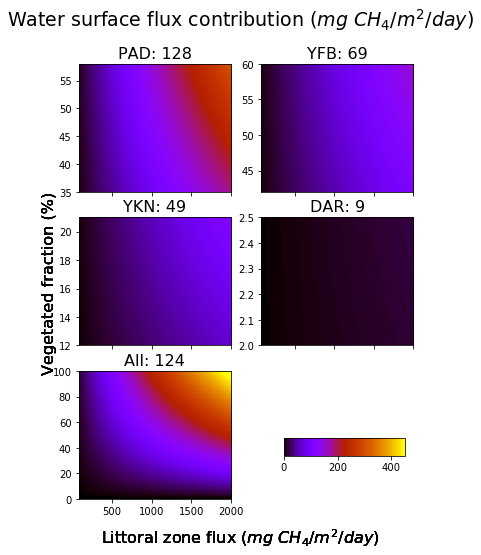

In [8]:
## Raster plot
# plt.xticks(FLUX_POSTINGS[0:4:])
# plt.yticks(FRACTION_POSTINGS[0:4:])
f=16 # font size
# ax=np.zeros((3,2))
shape=(3,2)
fig, ax = plt.subplots(shape[0], shape[1], sharex=True, figsize=(6,8))
for si, s in enumerate(SITES):
    idx=np.unravel_index(si, shape)
    p=ax[idx].imshow(SENSITIVITY[s], origin='lower', aspect='auto', cmap='gnuplot', vmin=0, vmax=450, extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))
#     ax[idx].set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f)
#     ax[idx].set_ylabel('Vegetated fraction (%)', fontsize=f)
    fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
    fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax[idx].set(xlabel="Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ylabel='Vegetated fraction (%)', fontsize=f)
#     ax[idx].set_title('{} | Total flux ($mg\ CH_4 / m^2 /day$)'.format(s), fontsize=f)
    ax[idx].set_title(f'{s}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
#     ax[idx].colorbar()
#     fig.tight_layout()
#     axes=plt.gca()
    # plt.rcParams({'dpi':300})
    # axes.set_xlim(FLUXES['EM'])
    # axes.set_ylim(FRACTION['EM'])
    # plt.xticks(FLUX_POSTINGS[0:4:])
    # plt.yticks(FRACTION_POSTINGS[0:4:])

    ## calculate median:
    cy, cx = ndi.center_of_mass(SENSITIVITY[s])

    ## report mean value:
#     print('Mean flux: \t{:.1f} mg CH_4/m^2/day'.format(np.mean(SENSITIVITY[s])))
#     print('\'Median\' flux: \t{:.1f} mg CH_4/m^2/day'.format(SENSITIVITY[s][cy.astype(int),cx.astype(int)])) # only equal to median if each step size is of equal prob.
#     print('''\nINPUTS:
#     FRACTION:\t{}
#     FLUXES:\t\t{}
#     '''.format(FRACTION, FLUXES))

    # common plot options
fig.suptitle('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f+3)
ax[shape[0]-1, shape[1]-1].axis('off')
# ax[shape[0]-1, shape[1]-1].colorbar()
cbaxes = fig.add_axes([0.6, 0.2, 0.28, 0.03]) 
fig.colorbar(p, cax=cbaxes, orientation='horizontal')
# fig.colorbar(p, ax=ax[shape[0]-1, shape[1]-1], orientation='horizontal')
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRaster.pdf'
plt.savefig(figPth, dpi=300)
print('Saved fig to:\t{}'.format(figPth))

Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.jpg


<Figure size 432x288 with 0 Axes>

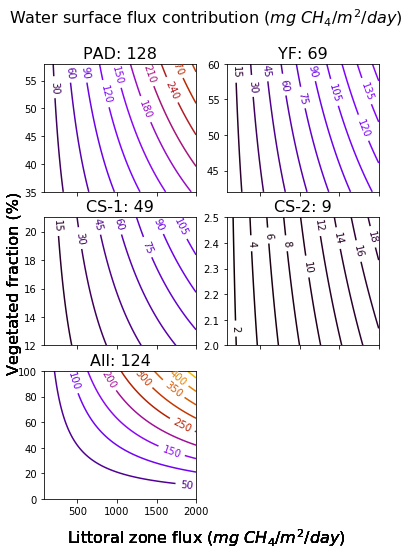

In [9]:
## Make contour plot
## TODO: fill in between lines
## from https://matplotlib.org/examples/pylab_examples/contour_label_demo.html

    # I/O
num_contours=10

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

##
plt.figure()

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(shape[0], shape[1], sharex=True, figsize=(6,8))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in enumerate(SITES):
    idx=np.unravel_index(si, shape)
        
        # define dims
    Y=FRACTION_POSTINGS[s]
    X=FLUX_POSTINGS['EM']
    Z=SENSITIVITY[s]
    
    # Basic contour plot
    CS = ax[idx].contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=500,
        extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax[idx].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#     ax[idx].set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f+2)
#     ax[idx].set_ylabel('Vegetated fraction (%)', fontsize=f)
    fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
    fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
    ax[idx].set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
#     plt.tight_layout()
    
    # plot format
plt.suptitle('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f)
ax[shape[0]-1, shape[1]-1].axis('off')

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.pdf'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.jpg'
plt.savefig(figPth, dpi=300)
print('Saved fig to:\t{}'.format(figPth))

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Log scale: values of z <= 0 have been masked


Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHists.pdf
Contour values: [6.25000000e-02 1.57564228e-01 3.97223773e-01 1.00141211e+00
 2.52458761e+00 6.36455515e+00 1.60452195e+01 4.04504417e+01
 1.01976682e+02 2.57086033e+02 6.48120996e+02 1.63393095e+03]


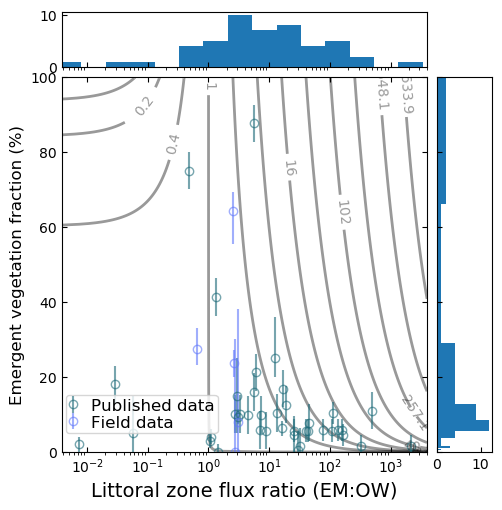

In [28]:
## Single contour plot with histograms v2 (log x, lin y)
%matplotlib inline
from math import log

f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY_RATIO['All']), 11) #10
xlim=dfr_j.CH4_flux_ratio.max() #200 # max x limit
# plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('default')
bins=20 # number of histogram bins

#####################linear x axis
# xlim=150
# xscale='linear'
# num_contours = np.arange(1, xlim*2, np.round(xlim/14)) # for linear xscale
# xlim_min=0
# xlim_max=xlim
#####################log x axis
xscale='log'
# num_contours = np.logspace(-1, np.log10(xlim*1), 10, base=10) # for log xscale
base=4 #np.e
num_contours = np.logspace(log(0.01, 10), log(xlim*100, 10), 12, base=base) # for log xscale
# num_contours = np.sort(np.append(np.logspace(log(0.01, 10), log(xlim*10, 10), 12), np.array([ 0.9, 0.95, 0.99, 1.01, 1.05, 1.1]))) # for log xscale
# num_contours = np.sort(np.hstack([num_contours, np.array([1.])]))
# num_contours = np.linspace(0.1, xlim*4, 10) # for log xscale
xlim_min=0.0005
bins_flux=np.logspace(np.log10(xlim_min), np.log10(xlim)+1, bins)
#############################
#####################linear y axis
yscale='linear'

#####################log y axis
# yscale='log'
# ylim_min=0.1
# bins_fraction=np.logspace(log(ylim_min), np.log10(100), bins)
#############################

# num_contours = np.linspace(1, xlim*2, 11) #10

## definitions for the axes
left, width = 0.12, 0.73
bottom, height = 0.1, 0.75
spacing = 0.02
hist_height = 1 - bottom - height - spacing*2 # 0.1

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, hist_height]
rect_histy = [left + width + spacing, bottom, hist_height, height]

## Define axes
plt.figure(figsize=(5,5)) # no effect: constrained_layout=True
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']): # unnecessary loop
        
        # define dims
    Y=FRACTION_RATIO_POSTINGS[s]
    X=FLUX_RATIO_POSTINGS['RATIO']
    Z=SENSITIVITY_RATIO[s]
    
    # Basic contour plot
    CS = ax_scatter.contour(X, Y, Z, num_contours, colors='k', cmap=None, alpha=0.4, \
                            norm=colors.LogNorm(0.5, vmax=num_contours[-1]), # norm=colors.LogNorm(vmin=0, vmax=xlim*1.3), #
        extent=(FLUXES['RATIO'][0], FLUXES['RATIO'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]), linewidths=2)

        # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]
    clabel_locs=[] #[(0.019, 91.70)]*10
    ax_scatter.clabel(CS, CS.levels, inline=True, fontsize=10, use_clabeltext =True, fmt=fmt) #, manual=clabel_locs)
    
    ax_scatter.set_xlabel("Littoral zone flux ratio (EM:OW)", fontsize=f+2)
    ax_scatter.set_ylabel('Emergent vegetation fraction (%)', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
ax_scatter.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 'o', color='#1C6A78', ecolor='#1C6A78', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
ax_scatter.errorbar(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, FRACTION_RATIO_FIELD_CI, None, 'o', color='#6178FA', ecolor='#6178FA', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)
# ax_scatter.set_xlim(0, xlim)
# # Add lake labels for each point: FIELD
# for x_pos, y_pos, label in zip(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, LAKE_LABELS_FIELD):
#     ax.annotate(label,             # The label for this point
#                 xy=(x_pos, y_pos), # Position of the corresponding point
#                 xytext=(7, 0),     # Offset text by 7 points to the right
#                 textcoords='offset points', # tell it to use offset points
#                 color='b',
#                 ha='left',         # Horizontally aligned to the left
#                 va='center')       # Vertical alignment is centered
    
# # Add lake labels for each point: LIT
# for x_pos, y_pos, label in zip(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, LAKE_LABELS_LIT):
#     ax.annotate(label,             # The label for this point
#                 xy=(x_pos, y_pos), # Position of the corresponding point
#                 xytext=(7, 0),     # Offset text by 7 points to the right
#                 textcoords='offset points', # tell it to use offset points
#                 color='k',
#                 ha='left',         # Horizontally aligned to the left
#                 va='center')       # Vertical alignment is centered
## histograms
ax_histx.hist(np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)), bins=bins_flux) # bins=bins # bins=50
ax_histy.hist(np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT)), bins=bins_fraction, orientation='horizontal')

## title
# ax_scatter.set_title('Water surface flux contribution ratio (total:OW)', fontsize=f-2)

## legend
ax_scatter.legend(['Published data', 'Field data'], loc=[0.01, 0.05], fontsize=f, borderpad= 0.2, labelspacing=0.1, handlelength=0.5) # loc=[0.01, 0.45]

## set window and axes

#####################linear axis
# ax_scatter.set_xlim(0, xlim_max) #FLUXES['RATIO'][1]/1) #FLUXES['RATIO'][1]/1)
################################

ax_scatter.set_xscale(xscale)
ax_scatter.set_yscale(yscale)


ax_histx.set_xlim(ax_scatter.get_xlim()) # ax_scatter.get_xlim() # 0,10
ax_histx.set_xscale(xscale)
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_yscale(yscale)


## style
# fig.linewidth(4)

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHists.jpg'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHists.pdf'
plt.savefig(figPth, dpi=300)

print('Saved fig to:\t{}'.format(figPth))
print('Contour values: {}'.format(num_contours))